#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
#from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
scale = lambda x: 3.+1.7*np.sin(np.pi*3*x)#*np.cos(2*np.pi*3*x+0.3)*5.+6. #np.sin(2*np.pi*3*x+.6)

(500, 2)


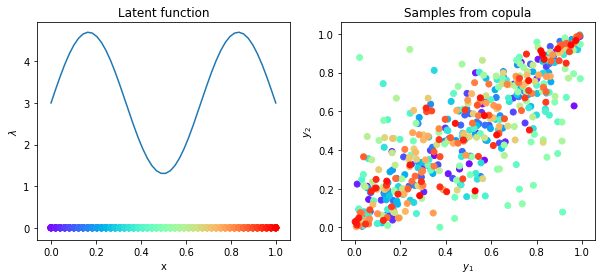

In [3]:
# here we generate some synthetic samples
import matplotlib.cm as cm
from gpytorch.distributions import base_distributions

NSamp = int(50)

X = np.linspace(0.,1.0,NSamp)

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

scales = np.clip([scale(x) for x in X]+0.0*base_distributions.Normal(0,1).sample(torch.Size([NSamp])).numpy(),1,20)
#scales = 0.8 - 0.5 * (np.random.rand(len(X))<0.5)
rep = 10
scales = np.repeat(scales,rep,axis=0)
X = np.repeat(X,rep,axis=0)
NSamp = NSamp*rep

lambdaf.plot(X,scales)
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

model = GumbelCopula(torch.tensor(scales).float())
Y = model.sample().numpy().squeeze()
print(Y.shape)
colors = cm.rainbow(np.linspace(0., 1., NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from copula')

fig.show()

In [4]:
Y[Y!=Y]

array([], dtype=float32)

In [5]:
Y[Y==1]

array([], dtype=float32)

In [6]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

In [7]:
# define the model (optionally on GPU)
grid_size = 128

#model = GPInferenceModel(train_x, GaussianCopula_Likelihood()).cuda(device=0)
#likelihood = GaussianCopula_Likelihood().cuda(device=0)
model = KISS_GPInferenceModel(GumbelCopula_Likelihood(), prior_rbf_length=0.1, grid_size=grid_size).cuda(device=0)

In [8]:
#model.likelihood.noise = 1e-4

In [9]:
# train the model

base_lr = 0.01
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.variational_strategy.variational_distribution.variational_mean},
    #hyperparameters
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .001}, #, 'lr': 0.001
    {'params': model.covar_module.raw_outputscale, 'lr': .001},
    #{'params': model.likelihood.noise_covar.raw_noise, 'lr': .001} #should change slower than variance
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
#mll  = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)
mllv = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=False)
#defauls mlls will call GH integration and equal weights for datapoints

losses, rbf, means = [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans=0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        assert torch.all(output.mean==output.mean)

        log_lik, kl_div, log_prior = mllv(output, train_y)
        loss = -(log_lik-kl_div+log_prior)

        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            print('Iter {}/{} - Loss: {:.3}, len: {:.3}, outscale: {:.3}, dLoss: {:.3}, \
            NaNs fixed: {}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(), 
                model.covar_module.raw_outputscale.item(),
                mean_p,
                nans
            ))
            nans=0

            if (0 < mean_p < 0.0001):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.

        # The actual optimization step
        loss.backward()
        for par in model.parameters():
            grad = par.grad.data
            nans+=torch.nonzero(grad!=grad).shape[0]
            if torch.any(grad.abs()==float('inf')):
                print("Grad inf... fixing...")
                grad = torch.clamp(grad,-1.,1.)
            grad[grad!=grad] = 0.0
            par.grad.data = grad
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
        assert torch.all(covar_grad==covar_grad)
        
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.01
Iter 100/2000 - Loss: -0.398, len: 0.102, outscale: -0.0722, dLoss: 0.0,             NaNs fixed: 0
Iter 200/2000 - Loss: -0.648, len: 0.109, outscale: -0.202, dLoss: 0.219,             NaNs fixed: 0
Iter 300/2000 - Loss: -0.702, len: 0.114, outscale: -0.298, dLoss: 0.0605,             NaNs fixed: 0
Iter 400/2000 - Loss: -0.718, len: 0.119, outscale: -0.367, dLoss: 0.0145,             NaNs fixed: 0
Iter 500/2000 - Loss: -0.723, len: 0.122, outscale: -0.41, dLoss: 0.00464,             NaNs fixed: 0
Iter 600/2000 - Loss: -0.725, len: 0.125, outscale: -0.428, dLoss: 0.00164,             NaNs fixed: 0
Iter 700/2000 - Loss: -0.726, len: 0.126, outscale: -0.426, dLoss: 0.00058,             NaNs fixed: 0
Iter 800/2000 - Loss: -0.726, len: 0.126, outscale: -0.409, dLoss: 0.000197,             NaNs fixed: 0
Iter 900/2000 - Loss: -0.726, len: 0.126, outscale: -0.385, dLoss: 6.7e-05,             NaNs fixed: 0
Converged!
CPU times: user 3min 15s, sys: 1.92 s, t

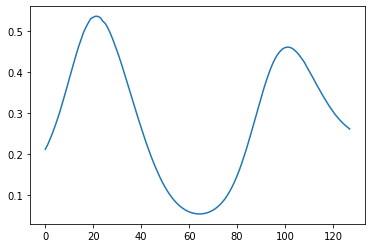

In [10]:
plt.plot(np.exp(means[-1]))
losses[losses!=losses] = 0

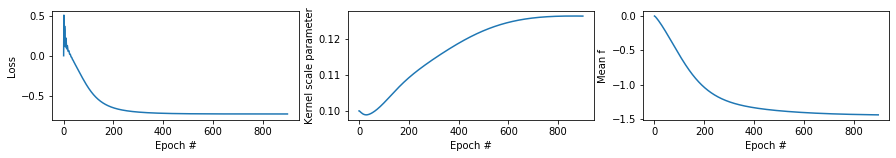

In [11]:
# prot loss function and kernel length
fig, ((lossp, kern, mean)) = plt.subplots(1,3,figsize=(15,2))
lossp.plot(losses)
lossp.set_xlabel("Epoch #")
lossp.set_ylabel("Loss")
lossp.set_ylim(np.min(losses)*1.1,np.max(losses)*1.1)
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [12]:
# define test set (optionally on GPU)
denser = 1 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

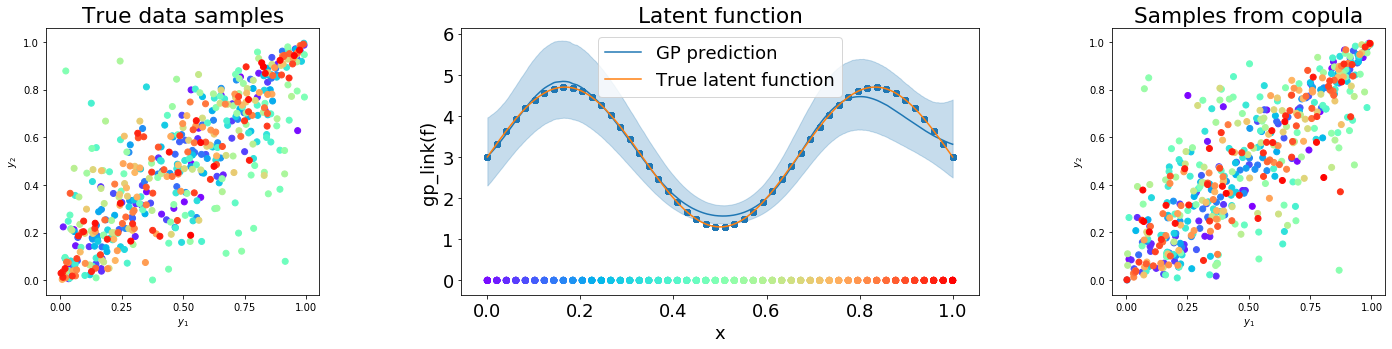

In [13]:
# visualize the result
fig, (true, nul0, nul, sim) = plt.subplots(1,4,figsize=(24, 4.9))

nul0.set_axis_off()
nul.set_axis_off()

plt.rcParams.update({'font.size': 18})

func = fig.add_axes([.365,0.125,.3,.755])

model.eval()
with torch.no_grad():
    #output = model(test_x)
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
 
#samples = output.rsample(torch.Size([int(1e5)]))
#F_mean = gplink(samples).mean(0).detach().cpu().numpy()
F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.25)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.scatter(X,scales)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    test_y = model.likelihood(model(train_x)).rsample()
    Y_sim = test_y.cpu().detach().numpy()
#model() -- returns GP (Multivariate normal) without noise
#model.likelihood(model) -- calls likelihood.marginal and adds noise (returns Multivariate normal)
#model.likelihood.forward(samples) -- returns copula samples
skip = 1
true.scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
sim.scatter(*Y_sim[...,::skip].T, label = 'Sample from the model', color=colors[::skip])
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula')
true.set_title('True data samples')
# samp.legend()

plt.subplots_adjust(wspace=0.3)

#plt.savefig('poster_img/gp.svg')

torch.Size([65, 500]) torch.Size([500, 2])
64 4.1588830833596715


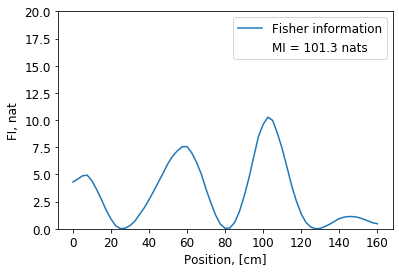

In [14]:
plt.rcParams.update({'font.size': 12})

ds = 2.5
n = int(160/ds)
samples = test_y.squeeze()
points = np.arange(n+1)/n

with torch.no_grad():
    thetas = gplink(model(torch.tensor(points).float().cuda(device=0)).mean)
    thetas = thetas.expand(samples.shape[-2:-1]+thetas.shape)
    thetas = torch.einsum('ij->ji', thetas) # now: [copulas, positions, samples]
    print(thetas.shape,samples.shape)
    logprob = model.likelihood.copula(thetas).log_prob(samples)
    #calculate FI
    FI = np.empty(n+1)
    FI[0] = ((logprob[0].exp())*((logprob[1]-logprob[0])/(ds/2)).pow(2)).sum().cpu().detach().numpy()
    FI[n] = ((logprob[n].exp())*((logprob[n]-logprob[n-1])/(ds/2)).pow(2)).sum().cpu().detach().numpy()
    for i in range(1,n):
        FI[i] = ((logprob[i].exp())*((logprob[i+1]-logprob[i-1])/ds).pow(2)).sum().cpu().detach().numpy()
    #now calculate MI    
    # P(r) = integral P(r|s) P(s) ds
    Pr = torch.zeros(samples.shape[0]).cuda(device=0)
    for i in range(n+1):
        Pr += logprob[i].exp().detach()*(1/(n+1))
    MIs=0
    for i in range(n+1):    
        MIs+= 1/(n+1)*logprob[i].exp()*(logprob[i]-Pr.log())
    MI = MIs.sum().detach().cpu().numpy()
    plt.plot(np.arange(n+1)*ds,FI,label='Fisher information')
    plt.plot(0,0,color='white',label='MI = {:.1f} nats'.format(MI))
    #plt.title("{} vs. {}".format(name1,name2))
    plt.xlabel('Position, [cm]')
    plt.ylabel('FI, nat')
    plt.ylim(0,20)
    plt.legend()
print(n,np.log(n))

In [17]:
cov = model(test_x).covariance_matrix

In [19]:
cov

tensor([[ 6.3309e-02,  6.2165e-02,  6.0863e-02,  ...,  2.5865e-05,
          9.9862e-06, -2.9131e-06],
        [ 6.2165e-02,  6.1152e-02,  6.0024e-02,  ...,  2.5921e-05,
          1.0838e-05, -1.5853e-06],
        [ 6.0863e-02,  6.0024e-02,  5.9164e-02,  ...,  2.5825e-05,
          1.1331e-05, -7.1934e-07],
        ...,
        [ 2.5865e-05,  2.5921e-05,  2.5825e-05,  ...,  6.2911e-02,
          6.3902e-02,  6.4856e-02],
        [ 9.9862e-06,  1.0838e-05,  1.1331e-05,  ...,  6.3902e-02,
          6.5162e-02,  6.6292e-02],
        [-2.9131e-06, -1.5853e-06, -7.1934e-07,  ...,  6.4856e-02,
          6.6292e-02,  6.7552e-02]], device='cuda:0', grad_fn=<SumBackward2>)